|  name             | email            | github      |
| ------            | ------           | ------      |
|Patrick Vongphakdy | pvong2@uic.edu   | patvong224  |
|Brian Zbojna       | bzbojn2@uic.edu  | bzbojn2     |
|Michael Carnowell  | mcarno2@uic.edu  | carnowell   |

https://github.com/CS418/group-project-team-import-antigravity

# Project Introduction


## Problem Statement and Questions

## Data

# DNF Analysis

## Data Cleaning

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
import string

standingsDF = pd.read_csv('driver_standings.csv')
lapTimesDF = pd.read_csv('lap_times.csv')
resultsDF = pd.read_csv('results.csv')

# Helper function to add DNF column
def DNFHelper(row):
    if row['positionText_x'] == 0:
        DNF = 1
    else:
        DNF = 0
    
    return DNF
    

helperDF = resultsDF

print("Before Cleaning: ", helperDF.shape, helperDF.columns)

# Replaces all of our DNFs to 0 to be used in our linear regression
helperDF = pd.merge(helperDF, standingsDF, on = ['driverId', 'raceId'])
helperDF = helperDF.replace(to_replace=['R', 'D', 'E', 'W', 'F', 'N'], value= 0, regex = True)

# Adding the DNF column to our dataframe
helperDF['DNF'] = helperDF.apply(DNFHelper, axis = 1)

allDF = helperDF.loc[:, helperDF.columns != 'positionText']

allDF = allDF.drop(['positionOrder'], axis = 1)
allDF = allDF.drop(['position_x'], axis = 1)
allDF = allDF.drop(['position_y'], axis = 1)
allDF = allDF.drop(['laps'], axis = 1)
allDF = allDF.drop(['positionText_x'], axis = 1)
allDF = allDF.drop(['positionText_y'], axis = 1)
allDF = allDF.drop(['points_x'], axis = 1)
allDF = allDF.drop(['statusId'], axis = 1)
allDF = allDF.drop(['time'], axis = 1)

allDF['fastestLapTime'] = allDF['fastestLapTime'].str.replace('[^\w\s]','')
allDF['fastestLapSpeed'] = allDF['fastestLapSpeed'].str.replace('[^\w\s]','')

allDF = allDF.fillna(0)

print("After Cleaning: ", allDF.shape, allDF.columns)

Before running our Linear Regression, we had to prune some of the columns off of our dataframe. Particularly, we got rid of the positionOrder, position_x, position_y, laps, positionText_x, positionText_y, points_x, and statusId. We had to get rid of these columns because they wouldn't be able to be used to predict a future DNF. Since these columns refer data collected AFTER the race, it's not much use for the task that we're looking to accomplish. We also had many missing fastestLapTimes and fastestLapSpeeds, so we filled in the NaN values with 0.

## Exploratory Data Analysis

In [ ]:
resultsDF.shape

We see that we have a very comprehensive dataset. We have 18 columns, and 25660 rows/entries.

In [ ]:
resultsDF.dtypes

Quantitative Discrete:
resultId, raceId, driverId, constructorId, number, grid, points, laps, milliseconds, fastestLap

Quantitative Continuous:
time, fastestLapTime, fastestLapSpeed

Categorical Nominal:
none

Categorical Ordinal:
position, positionText, positionOrder, rank

Some interesting pieces of data are the position and positionText columns. Position indicates the final position of a driver at that specific race. However, we know that some drivers don't necessarily finish every race, due to a number of issues. To circumnavigate this, we could use the positionOrder column, which indicates the final rank of a driver at a specific race. This allows us to collect data on final finishing positions without having to take DNF's into account.

Although we're able to bypass DNF's for the final finishing positions, the same can't be said for other data collected from that driver that race. For example, what happens when a driver can't complete a lap before they retire? We won't have that driver's fastestLapTime, fastestLapSpeed, and rank values. 

In [ ]:
podiumDF = resultsDF[['positionOrder', 'grid']]
podiumDF = podiumDF.loc[podiumDF['positionOrder'] <= 3]

podiumGraph = podiumDF['grid'].value_counts().plot.bar(figsize = (10, 10), title = 'Number of Podiums by Starting Grid Position')
podiumGraph.set_xlabel('Starting Grid Position')
podiumGraph.set_ylabel('Number of Podiums')

for label in podiumGraph.patches:
    podiumGraph.annotate(str(label.get_height()), (label.get_x(), label.get_height() * 1.02))

As we can see from the following visualization, out of 3,232 podium results, 1,761, or 54.49% were achieved from drivers who qualified in the top 3 positions. This indicates that qualifying top 3 is a large advantage in the final race.

In [ ]:
dnfDF = resultsDF[['grid', 'positionText']]
dnfDF = dnfDF.loc[dnfDF['positionText'] == 'R']

dnfGraph = dnfDF['grid'].value_counts().sort_index().plot.bar(figsize = (15, 10), title = 'Number of DNFs by Starting Grid Position',)
dnfGraph.set_xlabel('Starting Grid Position')
dnfGraph.set_ylabel('Number of DNFs')

for label in dnfGraph.patches:
    dnfGraph.annotate(str(label.get_height()), (label.get_x(), label.get_height() * 1.02))

This visualization shows an interesting trend. The top 11 grid positions in terms of number of DNFs are all in the bottom half of the possible starting grid positions. Additionally, these 11 grid positions account for 4464 total DNFs out of the 8781 overall DNFs. In other words, around 51% of DNFs came from drivers who started in these grid positions. This raises the question of why so many DNFs come from those starting grid positions. Are drivers further in the back of the pack more likely to get into crashes? Do these drivers push their cars harder to make up for their poor qualifying performances? 

## Machine Learning and Statistics

In [ ]:
xTrain, xTest, yTrain, yTest = train_test_split(allDF, helperDF.DNF, test_size = 0.2)

dnfRegression = LinearRegression()

rfe = RFE(estimator = dnfRegression, n_features_to_select = 4, step = 1)
rfe.fit(xTrain, yTrain)
# grid, rank, and wins are the top 3 features
print(rfe.support_)
print(rfe.ranking_)

topThreeFeats = helperDF[['rank', 'laps', 'grid']]

topXTrain, topXTest, topYTrain, topYTest = train_test_split(topThreeFeats, helperDF.DNF, test_size = 0.2)

rfeRegression = LinearRegression()

rfeRegression.fit(topXTrain, topYTrain)

rfeYPred = rfeRegression.predict(topXTest)
rfeYTrainPred = rfeRegression.predict(topXTrain)

As we can see, our RFE selects the top 3 features to predict whether or not a DNF will happen. The 3 features the RFE picked were grid, rank, and wins. Grid refers to the starting grid position, rank refers to the ranking of the driver's fastest lap, and wins refers to the number of wins that driver has that season.

## Results

In [ ]:
print('Intercept: ', rfeRegression.intercept_)

print('r-squared: %.2f' % r2_score(topYTest, rfeYPred))

print('for training: %.2f' % mean_squared_error(topYTrain, rfeYTrainPred))

print('for testing: %.2f' % mean_squared_error(topYTest, rfeYPred))

Our intercept is 0.89, meaning that if a driver starts from the pitlane, has the fastest lap time, and has no wins, they're very likely to DNF. Furthermore, our r-squared value is 0.48, meaning that the relationship between our regression and DNFs is around 48%. This means our model isn't the greatest fit for our data. Our Mean Squared Error values for both training and testing are around 0.12, meaning that we have a very low rate of error in prediction. This tells us that the three features the RFE picked are very effective in predicting a future DNF. 

# Pit Stop Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

ptdf = pd.read_csv("data/pit_stops.csv")
lpdf = pd.read_csv("data/lap_times.csv")

ptdf.rename(columns = {'lap':'pit_lap', 'time':'pit_time', 'milliseconds':'pit_ms'}, inplace = True)
df = pd.merge(ptdf, lpdf, on = 'driverId', how = 'inner')
df.drop('raceId_y', axis = 1, inplace = True)
df.head()

,raceId_x,driverId,stop,pit_lap,pit_time,duration,pit_ms,lap,position,time,milliseconds
0,841,153,1,1,17:05:23,26.898,26898,1,21,2:13.879,133879
1,841,153,1,1,17:05:23,26.898,26898,2,21,1:40.659,100659
2,841,153,1,1,17:05:23,26.898,26898,3,21,1:33.293,93293
3,841,153,1,1,17:05:23,26.898,26898,4,21,1:33.144,93144
4,841,153,1,1,17:05:23,26.898,26898,5,21,1:33.320,93320


We want to see if there is a correlation with pit stop times and lap times. I believe that we can truly see how important pit times are to winning lap times. In order to analyze a correlation, it would be best to merge the times together.We know that generations of racers and progression of technology can shorten both times, and this should still be present in our analysis.

Because of the massive size of the database, we need to get a random sample in order to get a proper graph. We also need to normalize the data in order to accurately present the data. This is because each circuit has varying lap and pit times due to the many different types of courses. From the circuit's length, corners, to DRS zones of each course, we would need a way to effectively show how the two times would correlate.

## Data Cleaning

In [2]:
df_norm_pt = df['pit_ms']/df['pit_ms'].abs().max()
df_norm_lp = df['milliseconds']/df['milliseconds'].abs().max()

There isn't much data to be cleaned, but here we will normalize the data for analysis on the correlation. 

## Exploratory Data Analysis

Text(0.5, 1.0, 'Normalized Laptimes & Pit Times Scatterplot')

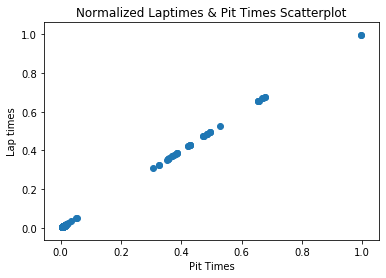

In [3]:
plt.scatter(df_norm_pt.sample(1500, random_state = 1), df_norm_pt.sample(1500, random_state = 1))
plt.xlabel('Pit Times')
plt.ylabel('Lap times')
plt.title("Normalized Laptimes & Pit Times Scatterplot")

From the normalized graph, we can see that there is a positive linear relationship between pit times and lap times. This is also from the random samples that we generated from the dataframe. Now this is just a visual representation of a small group of races and drivers.

We will dive deeper into finding correlations and 

## Machine Learning and Statistics

Now lets take a deeper dive into the correlations. We have made variables for the normalized times and will use that for our correlation testing.

In [4]:
#df_norm_times = pd.merge(df['pit_ms'], df['milliseconds'], right_index=True, left_index=True)
df[['pit_ms','milliseconds']].sample(1500, random_state = 1).corr()

,pit_ms,milliseconds
pit_ms,1.000000,-0.005835
milliseconds,-0.005835,1.000000


From this, we can that there actually isn't a correlation between the two variables. To see this more, let's use the original, un-normalized variables from the same random sample. We also decided to set a boundry for the plot to remove outliers.

(0, 500000)

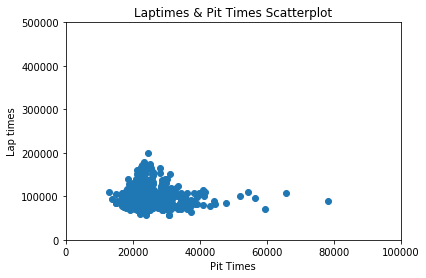

In [5]:
plt.scatter(df['pit_ms'].sample(1500, random_state = 1), df['milliseconds'].sample(1500, random_state = 1))
plt.xlabel('Pit Times')
plt.ylabel('Lap times')
plt.title("Laptimes & Pit Times Scatterplot")
plt.xlim([0,100000])
plt.ylim([0,500000])

Now lets use machine learning on predicting position with pit stops and milliseconds. We are using an SVM to classify different positions one could have with said times.

In [6]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df[['pit_ms', 'milliseconds']].sample(500, random_state = 1), 
    df['position'].sample(500, random_state = 1),
    test_size=0.20, random_state=0)

In [7]:
from sklearn import svm
from sklearn import metrics
clf = svm.SVC(kernel = 'linear')
clf.fit(x_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [8]:
y_pred = clf.predict(x_test)
print("Accuracy of SVM =", metrics.accuracy_score(y_test, y_pred))

Accuracy of SVM = 0.07


## Results

We can see that there is now no correlation between lap and pit times. Normalizing the data did not properly assess the two variables in finding a correlation. 
But using the corr function and using the base data, we can properly see that there is no correlation between teams and drivers pit times to lap times.

Our SVM model had a 0.07 accuracy, which means that the model was not accurate at all. This could add to Michael's theory that position; which is a direct correlation with points, doesn't matter and distributed evenly among drivers. This also leads to Michael's other statement thatwe can't predict a drivers finishing position from their times as well.

# Competition Analysis

## Data Cleaning

## Exploratory Data Analysis

## Machine Learning and Statistics

## Results

# References

1. https://www.geeksforgeeks.org/normalize-a-column-in-pandas/

2. https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html

3. https://sparkbyexamples.com/pandas/pandas-combine-two-series-into-dataframe/#:~:text=Combine%20Two%20Series%20Using%20pandas.&text=merge()%20can%20be%20used,True%2C%20left_index%3DTrue)%20.

4. https://www.datacamp.com/tutorial/svm-classification-scikit-learn-python
